# PoseNet for Self-Localization on Apolloscape Dataset

In [45]:
%load_ext autoreload
%autoreload 2

from IPython.display import HTML
from IPython.display import clear_output

import numpy as np

import torch
from torch import nn
from torchvision import transforms, models
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchviz import make_dot

from datasets.apolloscape import Apolloscape

from utils.common import draw_poses
from utils.common import draw_record
from utils.common import imshow
from utils.common import save_checkpoint
from utils.common import AverageMeter

from models.posenet import PoseNet, PoseNetCriterion

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from PIL import Image

from tqdm import tqdm
import os
import time
from datetime import datetime

%matplotlib inline
plt.ion()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Apolloscape Dataset

In [16]:
APOLLO_PATH = "./data/apolloscape"

# Resize data before using
transform = transforms.Compose([
    transforms.Resize(260),
    transforms.CenterCrop(250),
    transforms.ToTensor()
])


train_record = 'Record001'
train_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=train_record, normalize_poses=True,
                             pose_format='quat', train=True, cache_transform=True)

val_record = 'Record011'
val_dataset = Apolloscape(root=os.path.join(APOLLO_PATH), road="zpark-sample",
                             transform=transform, record=val_record, normalize_poses=True,
                             pose_format='quat', train=False, cache_transform=True)


print(train_dataset)
print(val_dataset)

train_dataloader = DataLoader(train_dataset, batch_size=8) # batch_size = 75
val_dataloader = DataLoader(val_dataset, batch_size=8) # batch_size = 75


Dataset: Apolloscape
    Road: zpark-sample
    Record: Record001
    Train: True
    Normalize Poses: True
    Length: 121 of 1121
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']

Dataset: Apolloscape
    Road: zpark-sample
    Record: Record011
    Train: False
    Normalize Poses: True
    Length: 87 of 378
    Cameras: ['Camera_2', 'Camera_1']
    Records: ['Record001', 'Record002', 'Record003', 'Record004', 'Record006', 'Record007', 'Record008', 'Record009', 'Record010', 'Record011', 'Record012', 'Record013', 'Record014']



## Draw Train and Val datasets

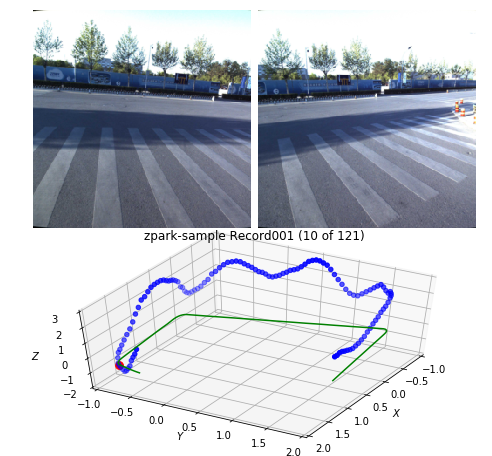

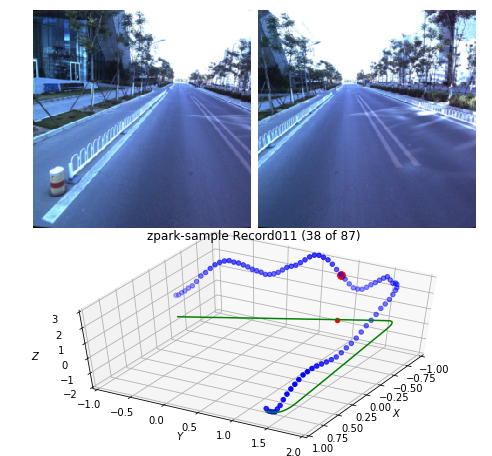

In [17]:
# Draw datasets
draw_record(train_dataset)
# plt.title('Train')
plt.show()

draw_record(val_dataset)
# plt.title('Val')
plt.show()

## Device set up

In [18]:
device = None
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('device = {}'.format(device))

device = cuda


## Train and Validate Functions

In [36]:
# train function
def train(train_loader, model, criterion, optimizer, epoch, max_epoch, log_freq=1, print_sum=True):
    
    # switch model to training
    model.train()
    
#     log_freq = 0
    
    losses = AverageMeter()
    
    end = time.time()
    for idx, (batch_images, batch_poses) in enumerate(train_loader):
#         if idx < len(train_loader) - 1: continue
        data_time = (time.time() - end)
        
        batch_images = [x.to(device) for x in batch_images]
        batch_poses = [x.to(device) for x in batch_poses]
        
        out = model(batch_images)
        loss = criterion(out, batch_poses)

        
        losses.update(loss, len(batch_images) * batch_images[0].size(0))
        
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time = (time.time() - end)
        end = time.time()
        
        if log_freq != 0 and idx % log_freq == 0:
            print('Epoch: [{}/{}]\tBatch: [{}/{}]\t'
                  'Time: {batch_time:.3f}\t'
                  'Data Time: {data_time:.3f}\t'
                  'Loss: {losses.val:.3f}\t'
                  'Avg Loss: {losses.avg:.3f}\t'.format(
                   epoch + 1, max_epoch, idx + 1, len(train_loader),
                   batch_time=batch_time, data_time=data_time, losses=losses))
            
    if print_sum:
        print('Epoch: [{}/{}]\tTraining Loss: {:.3f}'.format(epoch+1, max_epoch, losses.avg))
        
    return losses.avg
    
    
def validate(val_loader, model, criterion, epoch, log_freq=1, print_sum=True):
    
#     log_freq = 0 # len(val_loader)
    
    losses = AverageMeter()
    
    # set model to evaluation
    model.eval()
    
    with torch.no_grad():
        end = time.time()
        for idx, (batch_images, batch_poses) in enumerate(val_loader):
            data_time = time.time() - end
            batch_images = [x.to(device) for x in batch_images]
            batch_poses = [x.to(device) for x in batch_poses]
            
            # compute model output
            out = model(batch_images)
            loss = criterion(out, batch_poses)
            
            losses.update(loss, len(batch_images) * batch_images[0].size(0))
            
            batch_time = time.time() - end
            end = time.time()
            
            if log_freq != 0 and idx % log_freq == 0:
                print('Val Epoch: {}\t'
                      'Time: {batch_time:.3f}\t'
                      'Data Time: {data_time:.3f}\t'
                      'Loss: {losses.val:.3f}\t'
                      'Avg Loss: {losses.avg:.3f}'.format(
                       epoch + 1, batch_time=batch_time, data_time=data_time, losses=losses))
                
    
    if print_sum:
        print('Epoch: [{}]\tValidation Loss: {:.3f}'.format(epoch+1, losses.avg))
        
    return losses.avg


## Create Model, Criterion and Optimizer

In [29]:
# Create pretrained feature extractor
feature_extractor = models.resnet18(pretrained=True)

# Create model
model = PoseNet(feature_extractor)
model = model.to(device)

# Criterion
criterion = PoseNetCriterion()

# Create optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.0005)


## Restore from Chekpoint

In [21]:
# Restore from checkpoint
# checkpoint_file = '_checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar'

if 'checkpoint_file' in locals() and checkpoint_file is not None:
    if os.path.isfile(checkpoint_file):
        print('Loading from checkpoint: {}'.format(checkpoint_file))
        checkpoint = torch.load(checkpoint_file)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optim_state_dict'])
        start_epoch = checkpoint['epoch']


## Run Training

In [39]:
if 'start_epoch' not in locals():
    start_epoch = 0

n_epochs = start_epoch + 5
print('Training ...')
for e in range(start_epoch, n_epochs):

    end = time.time()
    train(train_dataloader, model, criterion, optimizer, e, n_epochs, log_freq=0)
    print('Train epoch time: {:.3f}'.format(time.time() - end))
    
#     print('Validation ...')
    end = time.time()
    validate(val_dataloader, model, criterion, e, log_freq=0)
    print('Validation epoch time: {:.3f}'.format(time.time() - end))


Training ...
Epoch: [1/300]	Training Loss: 1.096
Train epoch time: 1.927
Epoch: [1]	Validation Loss: 1.643
Validation epoch time: 1.257
Epoch: [2/300]	Training Loss: 0.942
Train epoch time: 1.908
Epoch: [2]	Validation Loss: 1.666
Validation epoch time: 1.247
Epoch: [3/300]	Training Loss: 0.886
Train epoch time: 1.904
Epoch: [3]	Validation Loss: 1.667
Validation epoch time: 1.253
Epoch: [4/300]	Training Loss: 0.990
Train epoch time: 1.903
Epoch: [4]	Validation Loss: 1.646
Validation epoch time: 1.253
Epoch: [5/300]	Training Loss: 0.649
Train epoch time: 1.907
Epoch: [5]	Validation Loss: 1.579
Validation epoch time: 1.258
Epoch: [6/300]	Training Loss: 0.798
Train epoch time: 1.915
Epoch: [6]	Validation Loss: 1.753
Validation epoch time: 1.253
Epoch: [7/300]	Training Loss: 0.821
Train epoch time: 1.917
Epoch: [7]	Validation Loss: 1.611
Validation epoch time: 1.250
Epoch: [8/300]	Training Loss: 0.693
Train epoch time: 1.904
Epoch: [8]	Validation Loss: 1.615
Validation epoch time: 1.252
Epo

Epoch: [67/300]	Training Loss: 0.406
Train epoch time: 1.935
Epoch: [67]	Validation Loss: 1.608
Validation epoch time: 1.269
Epoch: [68/300]	Training Loss: 0.392
Train epoch time: 1.922
Epoch: [68]	Validation Loss: 1.637
Validation epoch time: 1.268
Epoch: [69/300]	Training Loss: 0.599
Train epoch time: 1.922
Epoch: [69]	Validation Loss: 1.672
Validation epoch time: 1.273
Epoch: [70/300]	Training Loss: 0.407
Train epoch time: 1.931
Epoch: [70]	Validation Loss: 1.593
Validation epoch time: 1.270
Epoch: [71/300]	Training Loss: 0.353
Train epoch time: 1.932
Epoch: [71]	Validation Loss: 1.653
Validation epoch time: 1.268
Epoch: [72/300]	Training Loss: 0.608
Train epoch time: 1.933
Epoch: [72]	Validation Loss: 1.644
Validation epoch time: 1.268
Epoch: [73/300]	Training Loss: 0.360
Train epoch time: 1.936
Epoch: [73]	Validation Loss: 1.627
Validation epoch time: 1.269
Epoch: [74/300]	Training Loss: 0.365
Train epoch time: 1.937
Epoch: [74]	Validation Loss: 1.628
Validation epoch time: 1.267


Epoch: [132]	Validation Loss: 1.676
Validation epoch time: 1.454
Epoch: [133/300]	Training Loss: 0.390
Train epoch time: 2.138
Epoch: [133]	Validation Loss: 1.624
Validation epoch time: 1.459
Epoch: [134/300]	Training Loss: 0.442
Train epoch time: 2.108
Epoch: [134]	Validation Loss: 1.715
Validation epoch time: 1.429
Epoch: [135/300]	Training Loss: 0.758
Train epoch time: 2.122
Epoch: [135]	Validation Loss: 1.673
Validation epoch time: 1.458
Epoch: [136/300]	Training Loss: 0.409
Train epoch time: 2.118
Epoch: [136]	Validation Loss: 1.662
Validation epoch time: 1.447
Epoch: [137/300]	Training Loss: 0.329
Train epoch time: 2.119
Epoch: [137]	Validation Loss: 1.649
Validation epoch time: 1.456
Epoch: [138/300]	Training Loss: 0.502
Train epoch time: 2.114
Epoch: [138]	Validation Loss: 1.618
Validation epoch time: 1.422
Epoch: [139/300]	Training Loss: 0.414
Train epoch time: 2.212
Epoch: [139]	Validation Loss: 1.561
Validation epoch time: 1.461
Epoch: [140/300]	Training Loss: 0.364
Train ep

Epoch: [197/300]	Training Loss: 0.538
Train epoch time: 1.972
Epoch: [197]	Validation Loss: 1.639
Validation epoch time: 1.291
Epoch: [198/300]	Training Loss: 0.431
Train epoch time: 1.979
Epoch: [198]	Validation Loss: 1.671
Validation epoch time: 1.297
Epoch: [199/300]	Training Loss: 0.321
Train epoch time: 1.976
Epoch: [199]	Validation Loss: 1.747
Validation epoch time: 1.293
Epoch: [200/300]	Training Loss: 0.483
Train epoch time: 1.963
Epoch: [200]	Validation Loss: 1.677
Validation epoch time: 1.291
Epoch: [201/300]	Training Loss: 0.398
Train epoch time: 1.970
Epoch: [201]	Validation Loss: 1.668
Validation epoch time: 1.285
Epoch: [202/300]	Training Loss: 0.340
Train epoch time: 1.958
Epoch: [202]	Validation Loss: 1.674
Validation epoch time: 1.293
Epoch: [203/300]	Training Loss: 0.414
Train epoch time: 1.970
Epoch: [203]	Validation Loss: 1.674
Validation epoch time: 1.309
Epoch: [204/300]	Training Loss: 0.351
Train epoch time: 1.971
Epoch: [204]	Validation Loss: 1.650
Validation ep

Epoch: [262/300]	Training Loss: 0.340
Train epoch time: 2.257
Epoch: [262]	Validation Loss: 1.676
Validation epoch time: 1.478
Epoch: [263/300]	Training Loss: 0.352
Train epoch time: 2.301
Epoch: [263]	Validation Loss: 1.679
Validation epoch time: 1.438
Epoch: [264/300]	Training Loss: 0.423
Train epoch time: 2.215
Epoch: [264]	Validation Loss: 1.677
Validation epoch time: 1.453
Epoch: [265/300]	Training Loss: 0.307
Train epoch time: 2.092
Epoch: [265]	Validation Loss: 1.667
Validation epoch time: 1.292
Epoch: [266/300]	Training Loss: 0.315
Train epoch time: 1.967
Epoch: [266]	Validation Loss: 1.703
Validation epoch time: 1.292
Epoch: [267/300]	Training Loss: 0.378
Train epoch time: 1.963
Epoch: [267]	Validation Loss: 1.683
Validation epoch time: 1.299
Epoch: [268/300]	Training Loss: 0.284
Train epoch time: 1.977
Epoch: [268]	Validation Loss: 1.666
Validation epoch time: 1.288
Epoch: [269/300]	Training Loss: 0.344
Train epoch time: 1.967
Epoch: [269]	Validation Loss: 1.730
Validation ep

In [43]:
# for param_group in optimizer.param_groups:
#     print(param_group['lr'])

## Save Model Checkpoint

In [46]:
# Save checkpoint
save_checkpoint(model, optimizer, 'apollo_zpark_r001', n_epochs)
    

'_checkpoints/20180728_130156_apollo_zpark_r001_e300.pth.tar'